In [1]:
# use gpd_2023 environment

import numpy as np
#import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
#import seaborn as sns
import pickle
#import torch

from sklearn.metrics import average_precision_score # for precision-recall curve
from sklearn.metrics import roc_auc_score # for ROC curve
from sklearn.metrics import mean_squared_error
from sklearn.metrics import brier_score_loss

# prob not using here
import pandas as pd
import geopandas as gpd
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')) # for world map

# Configure Matplotlib to use LaTeX and Computer Modern
plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
    'font.serif': ['Computer Modern'],
})

In [1]:
def discard_ME_cells(views_vol, un_masked_matrix, feature, month, test_months):

    """
    Function to discard middle east cells from the matrix
    """

    # Hard coded...
    # For comparison with views 2020 where middle east is not included

    # 0 is ocean
    # You could load in the views replication data and get the c_id for only africa from there... More kosher
    middle_east_c_id = [ 0.0, 129.0, 130.0, 131.0, 128.0, 132.0, 133.0, 136.0, 55.0, 60.0, 62.0, 89.0, 218.0, 92.0, 220.0, 94.0, 93.0, 96.0, 119.0, 122.0, 124.0, 125.0, 126.0, 127.0]

    #middle_east_c_id = [0.0] # for debugging
    #middle_east_c_id = [] # for debugging


    # Values to mask (0 and 1 in this example)
    values_to_mask = np.array(middle_east_c_id)

    #for point estimates
    if un_masked_matrix.ndim == 4:

        # Create a mask for the specified values
        mask = np.isin(views_vol[-test_months, :, :, 4], values_to_mask)
        # Mask the array using the created mask
        masked_matrix = np.ma.masked_where(mask, un_masked_matrix[month, feature, :, :]) # [month, feature, :, :] is for the feature, i.e. type of violence

    # for posterior samples
    else:
        mask = np.isin(views_vol[-test_months, :, :, 4], values_to_mask)
        mask = np.broadcast_to(mask[np.newaxis, :, :], un_masked_matrix[:, month, feature, :, :].shape)
        #mask = np.broadcast_to(mask, un_masked_matrix.shape)

        # Mask the array using the created mask
        masked_matrix = np.ma.masked_where(mask, un_masked_matrix[:, month, feature, :, :]) # [month, feature, :, :] is for the feature, i.e. type of violence

    # Get the 1D vector with masked-out values discarded
    #vector = masked_matrix.compressed()

    return masked_matrix #vector

# masked_matrix = discard_ME_cells(mean_class_pred, 0)


In [3]:
def calculate_metrics(i, j, test_months, y_pred_array, y_class_pred_array, out_of_sample_vol, views_vol, metric_dict):

    # for point estimates
    y_score_masked_matrix = discard_ME_cells(views_vol, y_pred_array, j, i, test_months)
    y_score = y_score_masked_matrix.compressed()

    y_score_prob_masked_matrix = discard_ME_cells(views_vol, y_class_pred_array, j, i, test_months)
    y_score_prob = y_score_prob_masked_matrix.compressed()

    metric_dict = {"monthly/out_sample_month": i}

    y_true_masked_matrix = discard_ME_cells(views_vol, out_of_sample_vol.squeeze(), j, i, test_months)
    y_true = y_true_masked_matrix.compressed()
    y_true_binary = (y_true > 0) * 1

    mse = mean_squared_error(y_true, y_score)
    ap = average_precision_score(y_true_binary, y_score_prob)
    auc = roc_auc_score(y_true_binary, y_score_prob)
    brier = brier_score_loss(y_true_binary, y_score_prob)

    metric_dict[f"monthly/mean_squared_error{j}"] = mse
    metric_dict[f"monthly/average_precision_score{j}"] = ap
    metric_dict[f"monthly/roc_auc_score{j}"] = auc
    metric_dict[f"monthly/brier_score_loss{j}"] = brier

    return metric_dict

In [4]:
def calculate_metrics_sample(i, j, test_months, posterior_dict, views_vol, metric_dict):

    y_pred = np.array(posterior_dict['posterior_list'])
    y_pred_class = np.array(posterior_dict['posterior_list_class'])
    y_true = posterior_dict['out_of_sample_vol']
    y_true_stacked = np.repeat(y_true, 128, axis=0)
    y_true_binary_stacked = (y_true_stacked > 0) * 1

    y_pred_masked = discard_ME_cells(views_vol, y_pred, j, i, test_months)
    y_pred_class_masked = discard_ME_cells(views_vol, y_pred_class, j, i, test_months)

    y_true_masked = discard_ME_cells(views_vol, y_true_stacked, j, i, test_months)
    y_true_binary_masked = discard_ME_cells(views_vol, y_true_binary_stacked, j, i, test_months)

    mse_list = []
    ap_list = []
    auc_list = []
    brier_list = []

    for k in range(y_pred_masked.shape[0]):
        mse_list.append(mean_squared_error(y_true_masked[k].compressed(), y_pred_masked[k].compressed()))
        ap_list.append(average_precision_score(y_true_binary_masked[k].compressed(), y_pred_class_masked[k].compressed()))
        auc_list.append(roc_auc_score(y_true_binary_masked[k].compressed(), y_pred_class_masked[k].compressed()))
        brier_list.append(brier_score_loss(y_true_binary_masked[k].compressed(), y_pred_class_masked[k].compressed()))
    

    metric_dict[f"monthly/mean_squared_error_std{j}"] = np.array(mse_list).std()
    metric_dict[f"monthly/average_precision_score_std{j}"] = np.array(ap_list).std()
    metric_dict[f"monthly/roc_auc_score{j}_std"] = np.array(auc_list).std() 
    metric_dict[f"monthly/brier_score_loss{j}_std"] = np.array(brier_list).std()    

    return metric_dict


In [5]:

def make_df(n_features, test = False):

    local_dir_gen = '/home/simon/Documents/scripts/conflictNet/data/generated'
    local_dir_pro = '/home/simon/Documents/scripts/conflictNet/data/processed'

    if test == False:
        with open(f'{local_dir_gen}/posterior_dict_48_calib.pkl', 'rb') as file:
            posterior_dict = pickle.load(file)

        with open(f'{local_dir_pro}/viewser_monthly_vol_calib_sbnsos.pkl', 'rb') as file: 
            views_vol = pickle.load(file)
            

    else:
        with open(f'{local_dir_gen}/posterior_dict_36_test.pkl', 'rb') as file:
            posterior_dict = pickle.load(file)

        with open(f'{local_dir_pro}/viewser_monthly_vol_test_sbnsos.pkl', 'rb') as file: 
            views_vol = pickle.load(file)


    posterior_list = posterior_dict['posterior_list']
    posterior_list_class = posterior_dict['posterior_list_class']
    out_of_sample_vol = posterior_dict['out_of_sample_vol']

    test_months = out_of_sample_vol.shape[1]

    # Get mean each month - much fater to do this outside the loop
    mean_array = np.array(posterior_list).mean(axis = 0) 
    mean_class_array = np.array(posterior_list_class).mean(axis = 0) 

    # 
    metric_dict_list = []

    for i in range(test_months): 

        metric_dict = {}
        metric_dict["monthly/out_sample_month"] = i

        # Get mean
        for j in range(n_features):

            # means
            metric_dict.update(calculate_metrics(i, j, test_months, mean_array, mean_class_array, out_of_sample_vol, views_vol, metric_dict))
            metric_dict.update(calculate_metrics_sample(i, j, test_months, posterior_dict, views_vol, metric_dict))

        metric_dict_list.append(metric_dict)


    df = pd.DataFrame(metric_dict_list) 
    return df


In [6]:
def plot_monthly_ap(df):

    local_dir_plot = '/home/simon/Documents/scripts/conflictNet/reports/plots'

    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(10, 5))  # Adjust the figure size as needed

    # Data
    x = df['monthly/out_sample_month'] +1 #to start at 1 and end at last month
    y_state_based = df['monthly/average_precision_score0']
    y_one_sided = df['monthly/average_precision_score1']
    y_non_state_based = df['monthly/average_precision_score2']

    y_state_based_std = df['monthly/average_precision_score_std0']
    y_one_sided_std = df['monthly/average_precision_score_std1']
    y_non_state_based_std = df['monthly/average_precision_score_std2']

    # Plot the data with lines for each category
    ax.plot(x, y_state_based, color='#1f77b4', linestyle='-', linewidth=2, label='State Based')
    ax.plot(x, y_one_sided, color='#ff7f0e', linestyle='--', linewidth=2, label='One-Sided')
    ax.plot(x, y_non_state_based, color='#2ca02c', linestyle=':', linewidth=2, label='Non-State Based')

    # Shade the areas within 2x standard deviation
    ax.fill_between(x, y_state_based - 2 * y_state_based_std, y_state_based + 2 * y_state_based_std, color='#1f77b4', alpha=0.2)
    ax.fill_between(x, y_one_sided - 2 * y_one_sided_std, y_one_sided + 2 * y_one_sided_std, color='#ff7f0e', alpha=0.2)
    ax.fill_between(x, y_non_state_based - 2 * y_non_state_based_std, y_non_state_based + 2 * y_non_state_based_std, color='#2ca02c', alpha=0.2)

    # Set x-axis limits
    ax.set_xlim(1, x.max()+2)# +2 to end at last month

    # Set x-axis ticks every 6 months and limit the range to a maximum of 48 months
    x_ticks = np.arange(0, x.max()+2, 6) # +2 to end at last month
    ax.set_xticks(x_ticks)

    # Adjust spines (removing the top and right spines)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Set axis labels and title
    ax.set_xlabel('Out-of-sample Month', fontsize=12)
    ax.set_ylabel('Average Precision Score', fontsize=12)
    ax.set_title('Monthly Average Precision Score', fontsize=14)

    # Add a grid
    ax.grid(True, linestyle='--', alpha=0.6)

    # Add a legend
    ax.legend(loc='upper right', fontsize=10)

    # Customize tick labels
    ax.tick_params(axis='both', which='both', labelsize=10)

    # Add data points as dots
    ax.scatter(x, y_state_based, color='#1f77b4', s=10, label='Data Points (State Based)')
    ax.scatter(x, y_one_sided, color='#ff7f0e', s=10, label='Data Points (One-Sided)')
    ax.scatter(x, y_non_state_based, color='#2ca02c', s=10, label='Data Points (Non-State Based)')

    # Add text annotation
    # Adjust annotation positions based on your data
    #ax.annotate('Maximum (State Based)', xy=(x_max_state, y_max_state), xytext=(x_text, y_text),
    #            arrowprops=dict(facecolor='black', arrowstyle='->'),
    #            fontsize=10)

    # Tighten the layout
    plt.tight_layout()

    # Save or display the plot
    plt.savefig(f'{local_dir_plot}/ap_monthly.png', dpi=300) #other path...
    plt.show()


In [7]:
# not sure where I fucked up... se if -1 does a difference
n_features = 3
df = make_df(n_features, test= True) # abit silly that you make this every time...

In [8]:
df

,monthly/out_sample_month,monthly/mean_squared_error0,monthly/average_precision_score0,monthly/roc_auc_score0,monthly/brier_score_loss0,monthly/mean_squared_error_std0,monthly/average_precision_score_std0,monthly/roc_auc_score0_std,monthly/brier_score_loss0_std,monthly/mean_squared_error1,...,monthly/roc_auc_score1_std,monthly/brier_score_loss1_std,monthly/mean_squared_error2,monthly/average_precision_score2,monthly/roc_auc_score2,monthly/brier_score_loss2,monthly/mean_squared_error_std2,monthly/average_precision_score_std2,monthly/roc_auc_score2_std,monthly/brier_score_loss2_std
0,0,0.004919,0.267045,0.956126,0.006772,0.000037,0.005699,0.002187,0.000034,0.004995,...,0.003697,0.000014,0.002792,0.232226,0.941305,0.004187,0.000000e+00,0.011245,0.003410,0.000023
1,1,0.003905,0.283501,0.956852,0.006240,0.000051,0.007025,0.001156,0.000032,0.004304,...,0.006694,0.000014,0.003201,0.213315,0.890027,0.005207,6.984919e-10,0.006081,0.006553,0.000025
2,2,0.004516,0.163189,0.941755,0.006737,0.000048,0.005232,0.002010,0.000035,0.003703,...,0.004724,0.000014,0.003093,0.205214,0.957872,0.004103,2.328306e-10,0.010896,0.001424,0.000022
3,3,0.005001,0.260819,0.956371,0.006513,0.000043,0.005667,0.001831,0.000034,0.003595,...,0.004446,0.000014,0.003001,0.250940,0.936964,0.004659,4.656613e-10,0.009983,0.004826,0.000022
4,4,0.003319,0.221493,0.939051,0.005428,0.000043,0.008400,0.001972,0.000033,0.003217,...,0.004167,0.000014,0.003938,0.168051,0.903352,0.004815,0.000000e+00,0.005678,0.005260,0.000022
5,5,0.005589,0.296011,0.939178,0.006550,0.000044,0.006149,0.003307,0.000029,0.003116,...,0.003742,0.000014,0.003361,0.221168,0.899326,0.004781,6.984919e-10,0.006510,0.008541,0.000023
6,6,0.004442,0.226922,0.935637,0.006373,0.000035,0.006494,0.003818,0.000028,0.001911,...,0.003786,0.000012,0.003078,0.199859,0.899224,0.004919,0.000000e+00,0.007285,0.005786,0.000018
7,7,0.003828,0.252292,0.925087,0.005478,0.000045,0.006280,0.005352,0.000027,0.001506,...,0.003868,0.000012,0.003041,0.301882,0.924748,0.004398,2.328306e-10,0.009499,0.006158,0.000019
8,8,0.005896,0.325861,0.944070,0.006387,0.000045,0.007014,0.003555,0.000030,0.002592,...,0.006727,0.000012,0.002454,0.241748,0.943653,0.003866,4.656613e-10,0.010437,0.003981,0.000021
9,9,0.004368,0.322121,0.966413,0.005686,0.000030,0.008587,0.000917,0.000029,0.001893,...,0.006449,0.000012,0.004055,0.177075,0.948177,0.004701,4.656613e-10,0.008084,0.002942,0.000023


In [9]:
df.mean()

monthly/out_sample_month                1.750000e+01
monthly/mean_squared_error0             5.554682e-03
monthly/average_precision_score0        2.865123e-01
monthly/roc_auc_score0                  9.266229e-01
monthly/brier_score_loss0               6.637980e-03
monthly/mean_squared_error_std0         4.080798e-05
monthly/average_precision_score_std0    6.365710e-03
monthly/roc_auc_score0_std              4.008715e-03
monthly/brier_score_loss0_std           2.985764e-05
monthly/mean_squared_error1             2.165281e-03
monthly/average_precision_score1        7.147285e-02
monthly/roc_auc_score1                  8.894261e-01
monthly/brier_score_loss1               2.942711e-03
monthly/mean_squared_error_std1         1.600711e-10
monthly/average_precision_score_std1    8.569005e-03
monthly/roc_auc_score1_std              6.430652e-03
monthly/brier_score_loss1_std           1.260117e-05
monthly/mean_squared_error2             4.356549e-03
monthly/average_precision_score2        2.0164

In [15]:
4.356549e-03

0.004356549

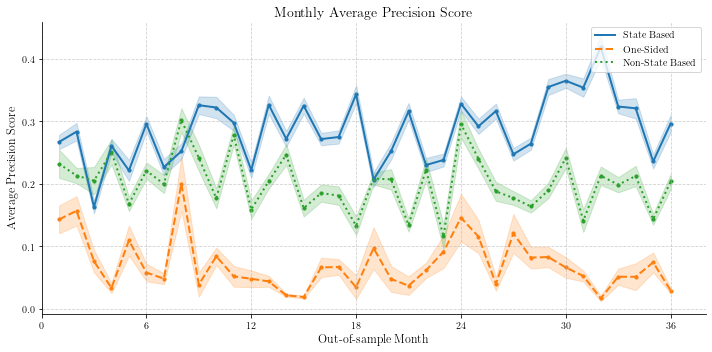

In [10]:
plot_monthly_ap(df)

In [11]:
# TEST WITH FULL THING TO SEE IF IT THENLOOKS ALIKE--

In [12]:
#14: #monthly/average_precision_score0        2.674998e-01 

# monthly/average_precision_score0        2.517857e-01
